In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import os
import numpy as np
from glob import glob
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import sys
import time
from plyer import notification

if __name__ == "__main__":
    print("Doing stuff...")
    time.sleep(30)
    while True:
        time.sleep(3)
        notification.notify(
            title = "Finished executing "+sys.argv[0],
            message = "Pastis Regression is done",
        )
        time.sleep(5)
        break



In [2]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = get_device()

In [3]:
class PASTISSegmentation(Dataset):
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        median_of_days: bool = False,
        Xmean = None,
        Xstd = None,
        binary_labels: bool = False,
        normalize:bool = True,
        transform = None,
        device = 'cpu'
    ) -> None:
        self.split = split
        self.transform = transform
        images = glob(os.path.join(image_dir, split, 'S2_*.npy'))
        self.images = images
        
        annotations = []
        for im in images:
            name = os.path.splitext(os.path.basename(im))[0].replace("S2_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.npy"))
        self.annotations = annotations
        # Store in the class for future reference
        self.median_of_days = median_of_days
        self.binary_labels = binary_labels
        
        self.Xmean  = Xmean
        self.Xstd = Xstd
        
    def __len__(self):
        return len(self.images)
    
    def read_data(self, files, median, norm=True):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
            r = np.load(im)
            if median:
                r = np.median(r, axis=0) #Take median value across 43 days
            if norm and self.Xmean is not None and  self.Xstd is not None:
                r = (r - self.Xmean) / self.Xstd
            t.append(r)
        return np.stack(t, axis=0)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.read_data([self.images[idx]], self.median_of_days)[0]
        y =  (self.read_data([self.annotations[idx]], median=False, norm=False)[0,0]).astype(np.int32)

        if self.binary_labels:
            y[y>0] = 1 # Convert to binary labels
            
            sample = {
             'X': torch.FloatTensor(X), 
             'y': torch.FloatTensor(y)
            }
        else:
            sample = {'X': torch.FloatTensor(X), 'y': torch.LongTensor(y)}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
base_path = r"C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\data_week4" # Define it

Xmean = np.array([ 596.57817383, 878.493514, 969.89764811, 1324.39628906, 2368.21767578, 2715.68257243, 2886.70323486, 2977.03915609, 2158.25386556, 1462.10965169])
Xmean = Xmean.reshape((10, 1, 1))
Xstd = np.array([251.33337853, 289.95055489, 438.725014, 398.7289996, 706.53781626, 832.72503267, 898.14189979, 909.04165075, 661.66078257, 529.15340992])
Xstd = Xstd.reshape((10, 1, 1))

p_train = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             median_of_days=True,
                             Xmean=Xmean,
                             Xstd=Xstd,
                             binary_labels=False, 
                             transform = None)

p_val = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="val",
                            median_of_days=True,
                            Xmean=Xmean,
                            Xstd=Xstd,
                            binary_labels=False, 
                            transform = None)

p_test = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="test",
                            median_of_days=True,
                            Xmean=Xmean,
                            Xstd=Xstd,
                            binary_labels=False, 
                            transform = None)

In [5]:
# Create a dataloader from the dataset
# Dataloader gives us the possibility to sample a mini-batches instead of only a single sample
BATCH_SIZE = 4 # Adjust the batch to fit the VRAM of the GPU
# If your BATCH_SIZE is too small then compensate for it by increasing the grad_accumulation in the training step

num_workers = 0 # Change depending upon the available hardware
train_dataloader = DataLoader(p_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=num_workers)

val_dataloader = DataLoader(p_val, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=num_workers)

test_dataloader = DataLoader(p_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=num_workers)


In [6]:
for d in train_dataloader:
    print(d['X'].shape, d['y'].shape, )
    print(d['X'].dtype, d['y'].dtype, )
    break

torch.Size([4, 10, 128, 128]) torch.Size([4, 128, 128])
torch.float32 torch.int64


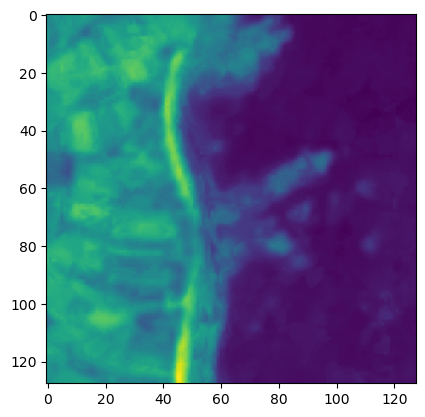

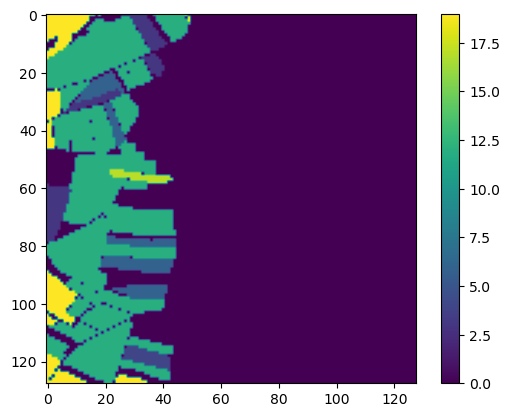

In [7]:
imd = 5
# Show the 3rd band of the third image
plt.imshow(p_train[imd]['X'][3].cpu().numpy())
plt.show()

# Show the labels for third image
plt.imshow(p_train[imd]['y'].cpu().numpy())
plt.colorbar()
plt.show()

# Neural Network

In [8]:
# Define our neural network

# Modified from: https://github.com/milesial/Pytorch-UNet
# GPL-3 license

class DoubleConv(nn.Module):
    """(convolution => [BN] => ELU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ELU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ELU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [9]:
# Define the evaluation loop
def eval_loop(model, val_loader, criterion):
#     print(f"Validating using the val_loader")
    epoch_loss_val = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            x, y_true = batch['X'].to(dtype=torch.float32, device=device), batch['y'].to(device=device)
            y_true = torch.squeeze(y_true, dim=1)
            y_pred = model(x).round().float()
           
            
            ### Calcualte loss
            loss = criterion(y_pred.float(), y_true.float())
            epoch_loss_val.append(loss.item())
    el = torch.mean(torch.FloatTensor(epoch_loss_val))
    model.train()
    return el

# Define the training loop
def train_loop(model, train_loader, val_loader, optimizer, criterion, epochs=50, grad_accumulation=1):
    train_loss = []
    val_loss = []
    n_train =  len(train_loader)
    for e in range(epochs):
        epoch_loss_train = []
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            print(f"Training on Batch: {batch_idx}")
            x, y_true = batch['X'].to(dtype=torch.float32, device=device), batch['y'].to(device=device)
            y_true = torch.squeeze(y_true, dim=1)
            y_pred = model(x).round().float()
           

            ### Calcualte loss
            loss = criterion(y_pred.float(), y_true.float())
            loss.backward()

            if (batch_idx + 1) % grad_accumulation == 0 or (batch_idx + 1 == n_train):
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss_train.append(loss.item())

        el = torch.mean(torch.FloatTensor(epoch_loss_train))
        print(f"Train loss for epoch {e}: {el}")
        train_loss.append(el)
        
        vel = eval_loop(model, val_loader, criterion)
        print(f"Validation loss for epoch {e}: {vel}")
        val_loss.append(vel)
        
    return model, train_loss, val_loss

In [10]:
# Define our first model
input_size = 10
output_size = 1

model = UNet(n_channels = input_size, n_classes = output_size)
model.to(device=device)
# Define the optimizer, the loss function and 
lr = 0.0001 # The learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Optimizer calculates the gradients and use it to update the model weights. 
criterion = nn.MSELoss(reduction='mean')

In [11]:
# Train the model
start_time = time.time()
epochs = 20

grad_accumulation = 4 # Accumulate grad over 4 batches

#Train the model for 50 epochs with CrossEntropry loss.
model, train_loss, val_loss = train_loop(model, train_dataloader, val_dataloader,  optimizer, criterion, epochs=epochs, grad_accumulation=grad_accumulation)
print(f"Trained for {epochs} epochs in {time.time()-start_time} seconds")

Training on Batch: 0


C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4, 128, 128])) that is different to the input size (torch.Size([4, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training on Batch: 1
Training on Batch: 2
Training on Batch: 3


C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3, 128, 128])) that is different to the input size (torch.Size([3, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss for epoch 0: 63.232276916503906


C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation loss for epoch 0: 75.8446273803711
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss for epoch 1: 65.87117767333984
Validation loss for epoch 1: 75.8446273803711
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss for epoch 2: 63.706905364990234
Validation loss for epoch 2: 75.8446273803711
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss for epoch 3: 64.29248046875
Validation loss for epoch 3: 75.84451293945312
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss for epoch 4: 64.0804443359375
Validation loss for epoch 4: 75.83702087402344
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss for epoch 5: 64.36819458007812
Validation loss for epoch 5: 75.790283203125
Training on Batch: 0
Training on Batch: 1
Training on Batch: 2
Training on Batch: 3
Train loss f

Task 2

C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4, 128, 128])) that is different to the input size (torch.Size([4, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(75.4923)


C:\Users\birgi\anaconda3\envs\DL\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


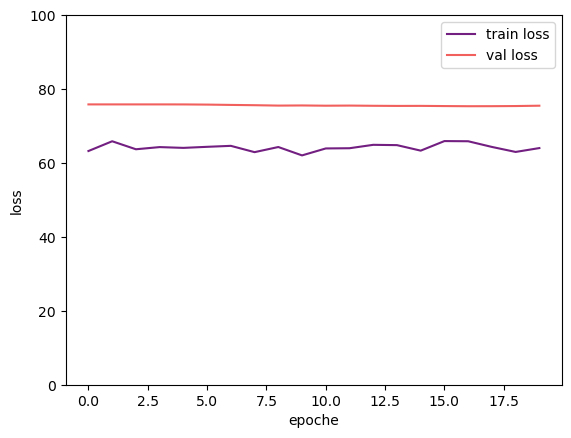

In [12]:
import pandas as pd

#create dataframe from train_loss convert and convert it to float
train_loss_1 = pd.DataFrame(train_loss).astype('float') 

#add new column indicating the type of loss (training or validation)
train_loss_1['loss type'] = 'train loss'

#adding epoch aa running number
train_loss_1['epoche'] = list(range(0,20,1))

#repeat for val_loss
val_loss_1 = pd.DataFrame(val_loss).astype('float')
val_loss_1['loss type'] = 'val loss'
val_loss_1['epoche'] = list(range(0,20,1))

#concat dfs and renaume to reflect the losses of model 1
loss_model_1 =pd.concat([train_loss_1, val_loss_1]).rename(columns = {0: 'loss model 1'})


import seaborn as sns
import matplotlib.pyplot as plt

#lineplot, with loss over epoch and type indicated by colour
model_1_plot = sns.lineplot(data = loss_model_1, x ='epoche', y = 'loss model 1', hue = 'loss type', palette = 'magma').set(xlabel='epoche', ylabel='loss')
plt.legend(title = False)
plt.ylim(0, 100)

print(eval_loop(model, val_dataloader, criterion))



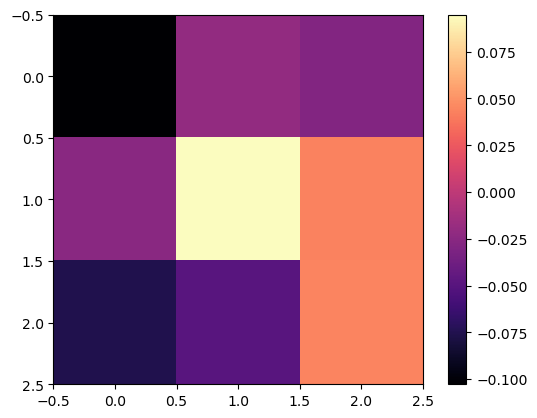

In [13]:
#get first convolutional layer
conv_layer = model.inc.double_conv[0]

#get weights
kernel_weights = conv_layer.weight.data

#convert to numpy array
kernel_weights_np = kernel_weights.numpy()

#plot
plt.imshow(kernel_weights_np[1, 0], cmap='magma')
plt.colorbar()
plt.show()

Task 3

In [14]:
# function for accuracy metrics
def calculate_metrics(model, dataloader):
    #set model to evaluation mode
    model.eval()
    
    #define variables for later use
    total_samples = 0
    correct_predictions = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    
    for batch_idx, batch in enumerate(test_dataloader):
           
        data, targets = batch['X'].to(dtype=torch.float32, device=device), batch['y']
        targets = torch.squeeze(targets, dim=1)
           
            
        #predict outputs and set labels to be the maximum probability
        outputs = model(data)
        _, predicted_labels = torch.max(outputs, dim=1)

            
        #define sample size as size of target set
        total_samples += targets.size(0)
            
        #define correct prediction logically as every pixel where the prediction is eqaul to the target
        correct_predictions += (predicted_labels == targets).sum().item()

        #similary define TP, FP and FN
        true_negatives += torch.sum(torch.logical_and(predicted_labels == 0, targets ==0 ))
        true_positives += torch.sum(torch.logical_and(predicted_labels == 1, targets == 1))
        false_positives += torch.sum(torch.logical_and(predicted_labels == 1, targets == 0))
        false_negatives += torch.sum(torch.logical_and(predicted_labels == 0, targets == 1))

    # calculate metrics        
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_positives + false_negatives)
    precision = true_positives.float() / (true_positives + false_positives)
    recall = true_positives.float() / (true_positives + false_negatives)

    return accuracy, precision.item(), recall.item()


#apply function
acc1, prec1, recall1 = calculate_metrics(model, val_dataloader)
acc1.to(dtype=torch.float32)

print('acc model 1:', acc1)
print('prec: model 1:', prec1)
print('recall model 1:', recall1)




acc model 1: tensor(0.5260)
prec: model 1: nan
recall model 1: 0.0
